In [274]:
import os
import random
import statistics

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import auxiliary
from auxiliary import form_sequences_dynamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import time
import timeit

In [275]:
'''LOAD DATASET'''
print("Loading Dataset")
df = pd.read_csv('merged_dataset_final.csv')
print(df['imeisv_ue'].unique())
print(df['imeisv_ue'].unique())

Loading Dataset
[3557821101183501 8609960468879056 8609960480666910 8609960480859056
 8628490433231156 8628490443809956 8642840401594200 8642840401612300
 8642840401624200]
[3557821101183501 8609960468879056 8609960480666910 8609960480859056
 8628490433231156 8628490443809956 8642840401594200 8642840401612300
 8642840401624200]


In [276]:
print(df)

               imeisv_ue  cell_X_cqi_ue  cell_X_dl_bitrate_ue  \
0       3557821101183501           14.0                5887.0   
1       3557821101183501           15.0                5718.0   
2       3557821101183501           14.0                5492.0   
3       3557821101183501           14.0                6091.0   
4       3557821101183501           14.0                5765.0   
...                  ...            ...                   ...   
122312  8642840401624200            9.0                2267.0   
122313  8642840401624200           10.0                2547.0   
122314  8642840401624200           10.0                2235.0   
122315  8642840401624200           10.0                2253.0   
122316  8642840401624200           10.0                2115.0   

        cell_X_dl_mcs_ue  cell_X_dl_retx_ue  cell_X_dl_tx_ue  cell_X_epre_ue  \
0                   21.8                3.0             20.0          -111.1   
1                   21.8                6.0             20.

In [277]:
feature_columns = ['total_dl_bytes_ue', 'total_ul_bytes_ue', 'cell_X_cqi_ue', 'cell_X_dl_bitrate_ue',
                    'cell_X_dl_retx_ue',  'cell_X_initial_ta_ue',
                   'cell_X_p_ue_ue', 'cell_X_pusch_snr_ue',
                   'cell_X_turbo_decoder_max_ue', 'cell_X_turbo_decoder_min_ue', 'cell_X_ul_bitrate_ue',
                   'cell_X_ul_mcs_ue',  'cell_X_ul_phr_ue', 'cell_X_ul_retx_ue',
                   'cell_X_ul_tx_ue', 'cell_X_dl_bitrate_cell', 'cell_X_dl_retx_cell',
                   'cell_X_dl_sched_users_avg_cell', 'cell_X_dl_sched_users_max_cell', 'cell_X_dl_tx_cell',
                   'cell_X_ue_active_count_avg_cell', 'cell_X_ue_active_count_max_cell',
                    'cell_X_ue_count_avg_cell', 'cell_X_ue_count_max_cell',
                   'cell_X_ue_count_min_cell', 'cell_X_ul_bitrate_cell', 'cell_X_ul_retx_cell',
                   'cell_X_ul_sched_users_avg_cell', 'cell_X_ul_sched_users_max_cell', 'cell_X_ul_tx_cell',
                   'cpu_cell', 'msg_ng_downlink_nas_transport_cell',
                   'rf_rx_cpu_time_cell', 'rf_rxtx_delay_avg_cell', 'rf_rxtx_delay_max_cell',
                   'rf_rxtx_delay_min_cell', 'rf_rxtx_delay_sd_cell', 'rf_samples_rx1_count_cell',
                   'rf_samples_rx1_max_cell', 'rf_samples_rx1_rms_cell', 'rf_samples_tx1_count_cell',
                    'rf_samples_tx1_rms_cell', 'rf_tx_count_cell', 'rf_tx_cpu_time_cell',
                   'rf_tx_sample_rate_cell']

In [278]:
# [3557821101183501  8609960480859056 8628490433231156
#  8642840401594200 8642840401612300 8642840401624200]

In [279]:
"""CREATE SEQUENCES OF CONSECUTIVE INSTANCES"""
seq_len = 12
print("Create Sequences with length: ", seq_len)

sequences_all = []
labels_all = []
data = df.copy()  
for _, group in data.groupby(['imeisv_ue', 'period_start', 'period_end']):
    sequences, labels, timestamps = form_sequences_dynamic(group, seq_len, feature_columns)
    sequences_all.extend(sequences)
    labels_all.extend(labels)
print("Number of sequence created for training and test data: ", len(sequences_all))

Create Sequences with length:  12
Number of sequence created for training and test data:  77141


In [280]:
# Convert lists to numpy arrays
sequences_all = np.array(sequences_all)
labels_all = np.array(labels_all)

In [281]:
print(sequences_all.shape)

(77141, 12, 45)


In [282]:
# Split the sequences into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_all, labels_all, test_size=0.2, random_state=42)

In [283]:
# Concatenate the sequences along the time axis
X_train_concat = X_train.reshape(-1, X_train.shape[2])
X_test_concat = X_test.reshape(-1, X_test.shape[2])

In [284]:
# Scale the concatenated sequences
scaler = StandardScaler()
X_train_scaled_concat = scaler.fit_transform(X_train_concat)
X_test_scaled_concat = scaler.transform(X_test_concat)
X_train_sc = X_train_scaled_concat.reshape(X_train.shape)
X_test_sc = X_test_scaled_concat.reshape(X_test.shape)

In [285]:
# Apply smote 
def apply_smote(X_train, y_train):
    # Reshape X_train for SMOTE
    num_samples, seq_length, num_features = X_train.shape
    X_train_reshaped = X_train.reshape(num_samples, seq_length * num_features)


    sampling_strategy = {1: 5000}
    # Apply SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Total number of sequences after resampling: {len(y_train_resampled)}")
    print(f"Number of sequences with label 0: {sum(y_train_resampled == 0)}")
    print(f"Number of sequences with label 1: {sum(y_train_resampled == 1)}")
    # Reshape back to original shape
    X_train_resampled = X_train_resampled.reshape(-1, seq_length, num_features)

    return X_train_resampled, y_train_resampled

# Apply SMOTE to balance the training data
X_train_resampled, y_train_resampled = apply_smote(X_train_sc, y_train)

Total number of sequences after resampling: 66245
Number of sequences with label 0: 61245
Number of sequences with label 1: 5000


In [286]:
def build_and_train_classifier(X_train, y_train, seq_length, num_features):
    model = Sequential()
    model.add(LSTM(64, input_shape=(seq_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=15, batch_size=256, validation_split=0.2)
    return model, history

In [287]:
# Build and train the classifier
num_features = X_train.shape[2]
num_classes = len(np.unique(labels))
model, history = build_and_train_classifier(X_train_resampled, y_train_resampled, seq_length, num_features)

Epoch 1/15


C:\Users\sc02449\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9602 - loss: 0.1554 - val_accuracy: 0.6524 - val_loss: 0.9707
Epoch 2/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9924 - loss: 0.0258 - val_accuracy: 0.6862 - val_loss: 0.5047
Epoch 3/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9936 - loss: 0.0176 - val_accuracy: 0.9211 - val_loss: 0.3461
Epoch 4/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.8869 - val_loss: 0.3770
Epoch 5/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9958 - loss: 0.0122 - val_accuracy: 0.8891 - val_loss: 0.3454
Epoch 6/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9964 - loss: 0.0111 - val_accuracy: 0.9162 - val_loss: 0.3343
Epoch 7/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9980 - loss: 0.0076 - val_accuracy: 0.9417 - val_loss: 0.2237
Epoch 8/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9977 - loss: 0.0094 - val_accuracy: 0.926

In [288]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9990926177976538
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15316
           1       0.97      0.90      0.94       113

    accuracy                           1.00     15429
   macro avg       0.99      0.95      0.97     15429
weighted avg       1.00      1.00      1.00     15429

             precision recall f1-score       support
0               0.9993 0.9998   0.9995  15316.000000
1               0.9714 0.9027   0.9358    113.000000
accuracy        0.9991 0.9991   0.9991      0.999093
macro avg       0.9854 0.9512   0.9677  15429.000000
weighted avg    0.9991 0.9991   0.9991  15429.000000
False Positive Rate (FPR): 0.0002
False Positive Rate (FPR): 0.02%


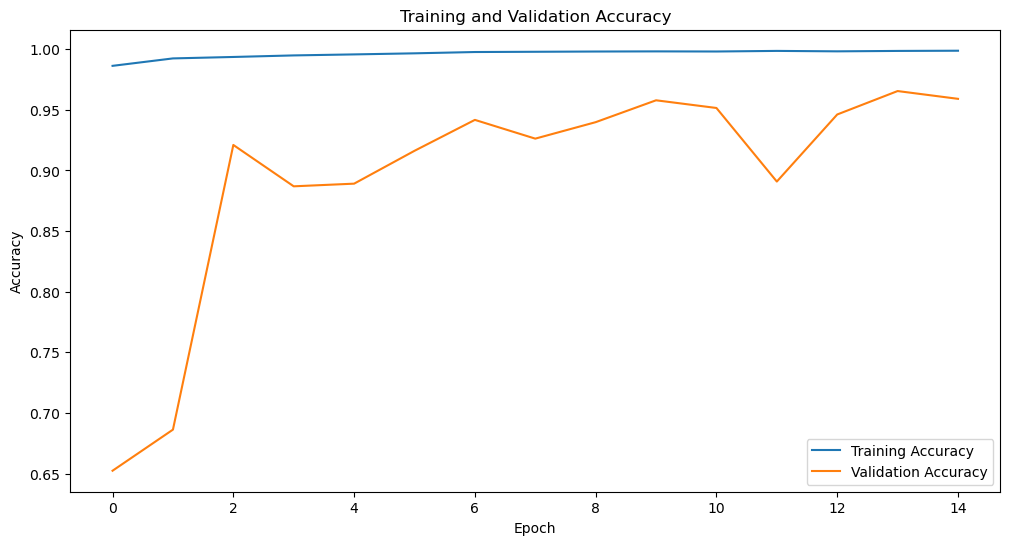

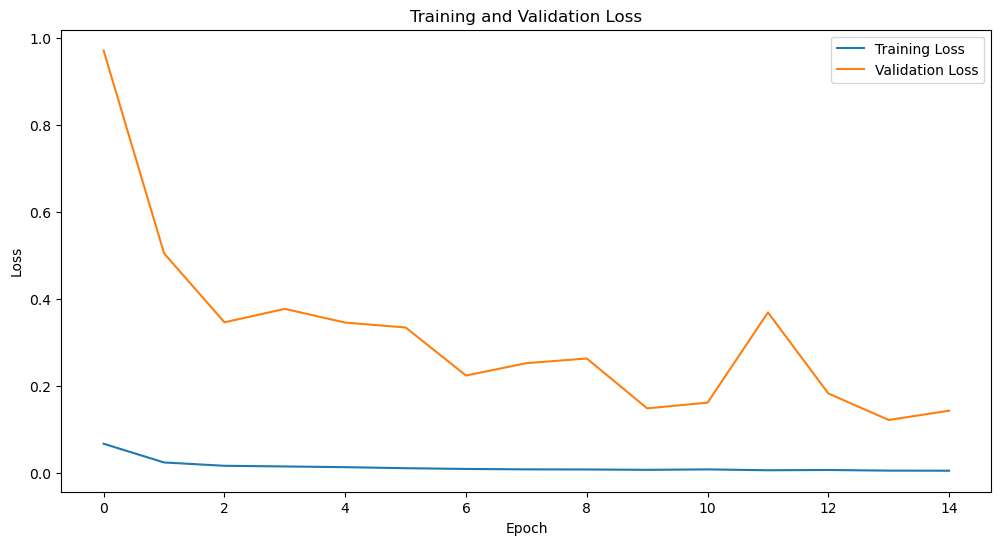

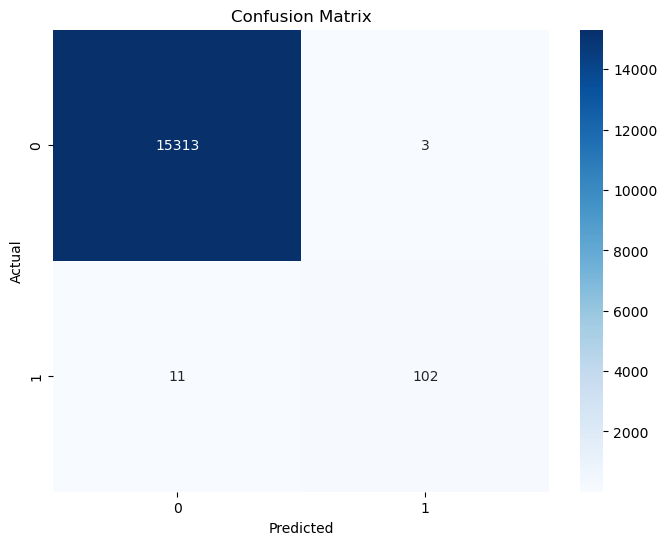

In [289]:
# Evaluate the classifier
y_pred = (model.predict(X_test_sc) > 0.5).astype("int32")
y_pred_proba = model.predict(X_test_sc)

# Print performance metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Generate classification report with more decimal points
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string(formatters={'precision': '{:.4f}'.format, 'recall': '{:.4f}'.format, 'f1-score': '{:.4f}'.format}))

# Calculate and print FPR
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
print(f"False Positive Rate (FPR): {fpr:.4f}")
fpr_percentage = fpr * 100
print(f"False Positive Rate (FPR): {fpr_percentage:.2f}%")

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [290]:
def perf_eval(y_test, y_pred, classifier):
    # print('Performance of classifier: ', classifier)
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    # print(cm)
    # Compute other statistics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print("{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{},{},{},{}".format(accuracy, precision, recall, f1, roc_auc, TN, FP, FN,
                                                              TP))
    classes = ['Benign', 'DDoS']
    report = classification_report(y_test, y_pred)

In [291]:
perf_eval(y_test,y_pred,'LSTM')

0.9991,0.9714,0.9027,0.9358,0.9512,15313,3,11,102
